# Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import nltk
import string
from category_map import category_map
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import dask.bag as db
from pylatexenc.latex2text import LatexNodes2Text
import json


plt.style.use('seaborn')
tqdm.pandas()

# Read data

In [2]:
category_map

{'astro-ph': 'Astrophysics',
 'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
 'astro-ph.EP': 'Earth and Planetary Astrophysics',
 'astro-ph.GA': 'Astrophysics of Galaxies',
 'astro-ph.HE': 'High Energy Astrophysical Phenomena',
 'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
 'astro-ph.SR': 'Solar and Stellar Astrophysics',
 'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
 'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
 'cond-mat.mtrl-sci': 'Materials Science',
 'cond-mat.other': 'Other Condensed Matter',
 'cond-mat.quant-gas': 'Quantum Gases',
 'cond-mat.soft': 'Soft Condensed Matter',
 'cond-mat.stat-mech': 'Statistical Mechanics',
 'cond-mat.str-el': 'Strongly Correlated Electrons',
 'cond-mat.supr-con': 'Superconductivity',
 'cs.AI': 'Artificial Intelligence',
 'cs.AR': 'Hardware Architecture',
 'cs.CC': 'Computational Complexity',
 'cs.CE': 'Computational Engineering, Finance, and Science',
 'cs.CG': 'Computational Geometry',
 'cs.CL

In [3]:
docs = db.read_text('data/arxiv-metadata-oai-snapshot.json').map(json.loads)
print(f'Число статей {docs.count().compute()}')

Число статей 2036497


In [4]:
docs.take(3)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [5]:
def flatten(record):
    return {'id' : record['id'], 'authors' : record['authors'], 'title' : record['title'], 'categories' :
        record['categories'].split(' '), 'abstract' : record['abstract']}

In [6]:
get_latest_version = lambda x: x['versions'][-1]['created']



columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2018)
           .map(flatten).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [7]:
docs_df.head()

,id,authors,title,categories,abstract
0,0704.0479,T.Geisser,The affine part of the Picard scheme,"[math.AG, math.KT]",We describe the maximal torus and maximal un...
1,0704.1445,Yasha Gindikin and Vladimir A. Sablikov,Deformed Wigner crystal in a one-dimensional q...,"[cond-mat.str-el, cond-mat.mes-hall]",The spatial Fourier spectrum of the electron...
2,0705.0033,"Nikos Frantzikinakis, Randall McCutcheon",Ergodic Theory: Recurrence,[math.DS],We survey the impact of the Poincar\'e recur...
3,0705.0344,J. P. Pridham,Unifying derived deformation theories,[math.AG],We develop a framework for derived deformati...
4,0705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,"[gr-qc, astro-ph, hep-th]",The mysterious `dark energy' needed to expla...


In [8]:
docs_df.drop_duplicates(['abstract',], inplace=True)
docs_df['categories_full'] = docs_df['categories'].apply(lambda x: x[0])
docs_df['categories'] = docs_df['categories'].apply(lambda x: x[0].split('.')[0])

In [9]:
docs_df[['categories_full']].groupby(['categories_full']).count()

""
categories_full
alg-geom
astro-ph
astro-ph.CO
astro-ph.EP
astro-ph.GA
...
stat.AP
stat.CO
stat.ME


In [10]:
docs_df.shape

(600231, 6)

In [11]:
docs_df.to_csv('to_use.csv')

In [12]:
df = docs_df.copy()

In [13]:
def clean_abstract(txt, stp_wrds):
    txt = txt.lower()
    try:
        txt = LatexNodes2Text().latex_to_text(txt)
    except:
        txt = txt.lower()
    sup = word_tokenize(txt, language="english")
    lemmatizer = WordNetLemmatizer()
    sup = [lemmatizer.lemmatize(word) for word in sup]
    ret = []
    for el in sup:
        el.replace('\\', '')
        if el not in stp_wrds and el not in string.punctuation:
            ret.append(el)
    return ' '.join(ret)


stop_words = nltk.corpus.stopwords.words("english")
stop_words += ['we', 'paper', 'new', 'article', "''", "``", "”", 'et', 'al', 'study', 'state', 'of', 'the', 'art']
cleaned_abstract = df['abstract'].progress_apply(clean_abstract, args=[stop_words])
df['abstract_uncleaned'] = df['abstract'].copy()
df['abstract'] = cleaned_abstract

  0%|          | 0/600231 [00:00<?, ?it/s]

In [14]:
normal_cats = {'math': 'math',
               'cond-mat': 'condensed matter',
               'math-ph' : 'mathematical physics',
               'astro-ph': 'Astrophysics',
               'cs': 'computer science',
               'econ': 'econometrics',
               'alg-geom' : 'math',
               'funct-an': 'math',
               'eess': 'electrical engineering and systems science',
               'gr-qc': 'general relativity and quantum cosmology',
               'hep-ex': 'high energy physics',
               'hep-lat': 'high energy physics',
               'hep-ph': 'high energy physics',
               'hep-th': 'high energy physics',
               'nlin': 'nonlinear sciences',
               'nucl-ex': 'nuclear experiment',
               'nucl-th': 'nuclear theory',
               'physics': 'physics',
               'q-bio': 'quantitative biology',
               'q-fin': 'quantitative finance',
               'quant-ph': 'quantum physics',
               'stat': 'statistics',
               'q-alg': 'quantitative algebra'}

In [15]:
df['category_normal'] = df['categories'].apply(lambda x: normal_cats[x])

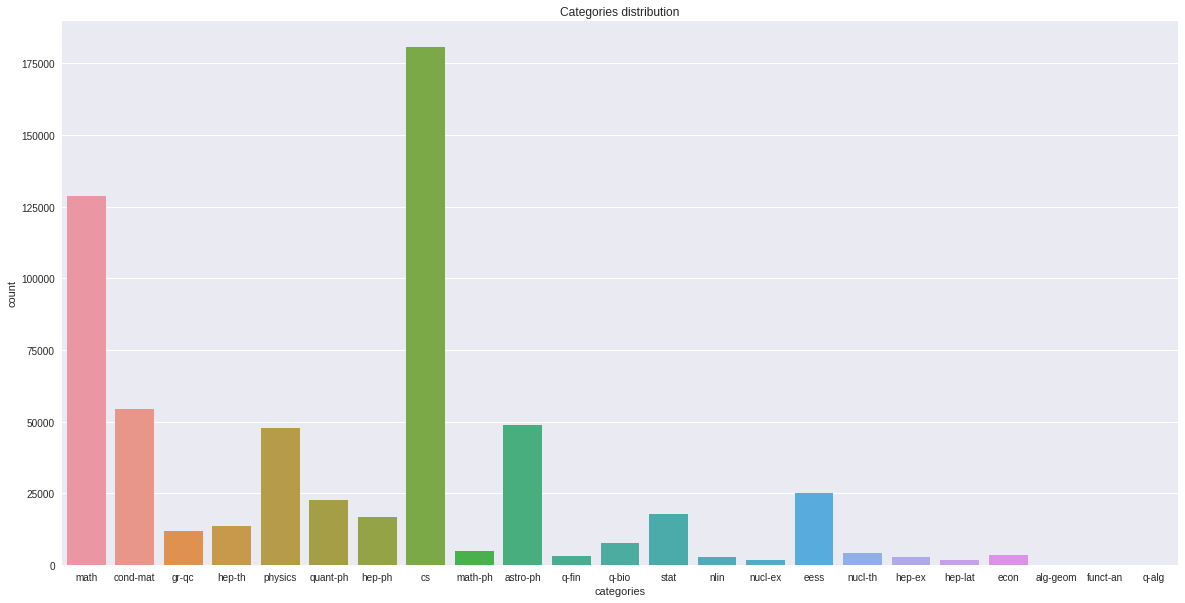

In [16]:
_, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Categories distribution')
_ = sns.countplot(data=df, x='categories', ax=ax)

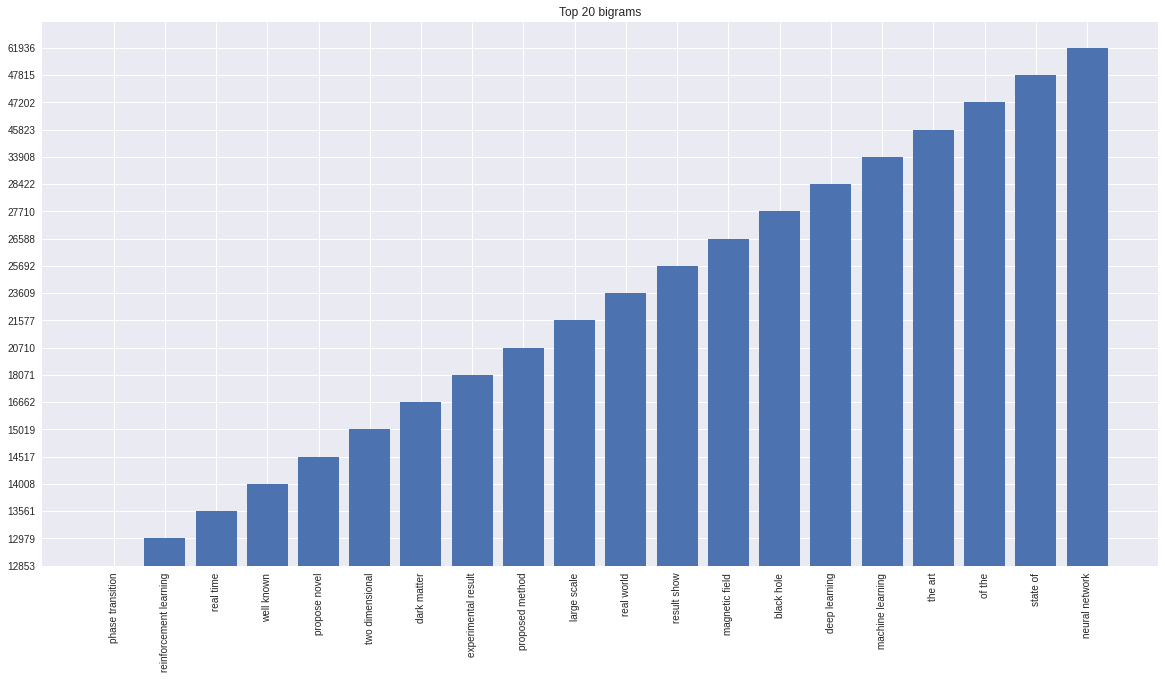

In [17]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [[word, sum_words[0, idx]] for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return np.array(words_freq[:n])

common_words = get_top_n_bigram(cleaned_abstract, 20)
common_words.sort()
common_words = np.flip(common_words)
x = common_words[:, 0]
y = common_words[:, 1]
_, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Top 20 bigrams')
_ = ax.bar(x, y, align='center', bottom=0)
_= plt.xticks(rotation=90)

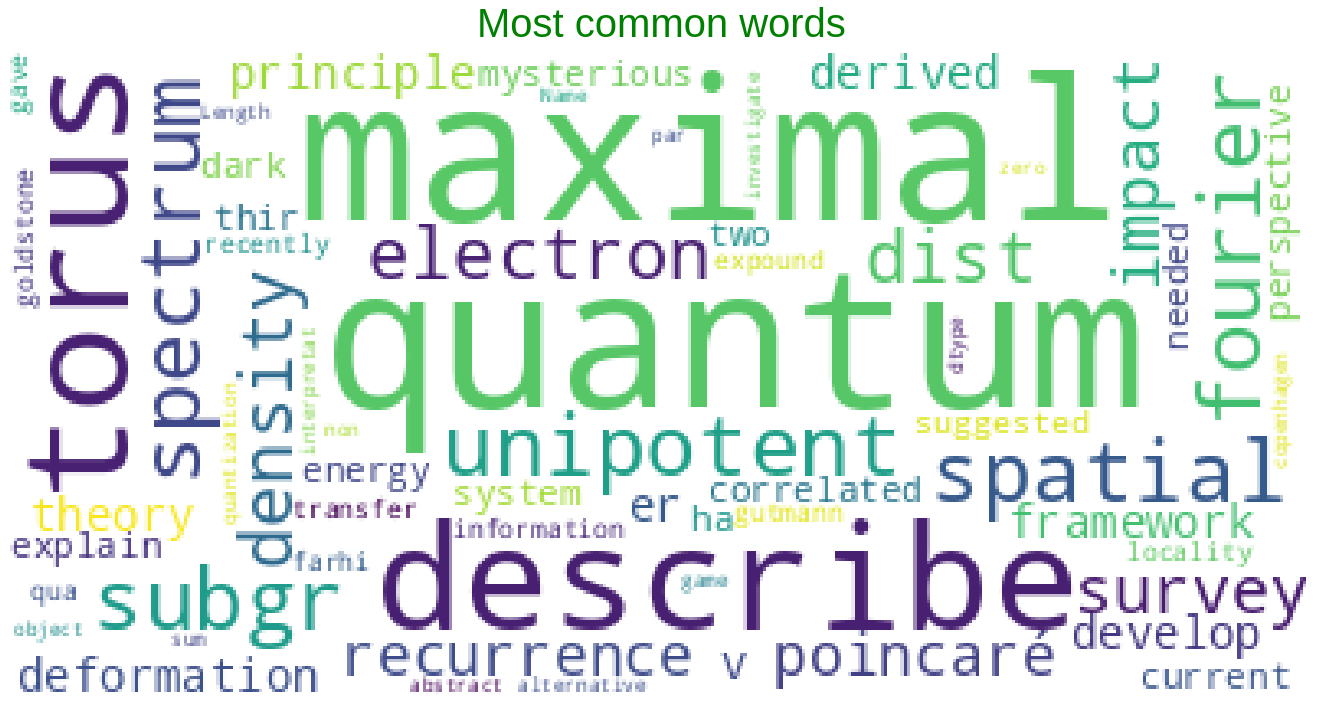

In [18]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                          stopwords = stopwords,
                          max_words = max_words,
                          max_font_size = max_font_size,
                          random_state = 42,
                          mask = mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                   'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green',
                                   'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

plot_wordcloud(str(df['abstract']), max_words=800, max_font_size=60, figure_size=(20, 10),
               title = 'Most common words')